# Molecular Cross-Validation for the Standard Seurat Pipeline in Scanpy

We demonstrate how to integrate MCV into the standard pipeline of normalization, PCA, UMAP and clustering.

MCV is used to select the optimal number of PCs, after highly variable gene selection. An arbitrary normalization recipe can be specified, and we perform MCV using a 50-50 split.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc

from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [2]:
def recipe_seurat(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    return adata

def mcv_calibrate_pca(adata, recipe, max_pcs = 30):
    from scipy.sparse import issparse

    X = adata.raw.X
    if issparse(X):
        X = np.array(X.todense())
    if np.allclose(X, X.astype(np.int)):
        X = X.astype(np.int)
    else:
        raise TypeError("Molecular cross-validation requires integer count data.")
    
    X1 = np.random.binomial(X, 0.5).astype(np.float)
    X2 = X - X1
    
    adata1 = sc.AnnData(X = X1)
    adata2 = sc.AnnData(X = X2)
    
    adata1 = recipe(adata1)
    adata2 = recipe(adata2)
    
    max_pcs = np.maximum(max_pcs, 30)
    
    sc.tl.pca(adata1, n_comps=max_pcs, zero_center=False, random_state = 1)
    
    k_range = np.concatenate([np.arange(2, 10, 1), np.arange(10, 30, 2), np.arange(30, max_pcs, 5)])
    
    mcv_loss = np.zeros(len(k_range))
    rec_loss = np.zeros(len(k_range))
        
    for i, k in enumerate(tqdm(k_range)):
        reconstruction = adata1.obsm['X_pca'][:,:k].dot(adata1.varm['PCs'].T[:k])
        mcv_loss[i] = mean_squared_error(reconstruction, adata2.X)
        rec_loss[i] = mean_squared_error(reconstruction, adata1.X)
    
    optimal_k = k_range[np.argmin(mcv_loss)]
    
    mcv_summary = {'k_range': k_range,
                       'mcv_loss': mcv_loss,
                       'rec_loss': rec_loss}
    return optimal_k, mcv_summary

def plot_mcv(mcv_summary):
    plt.plot(mcv_summary['k_range'], mcv_summary['mcv_loss'])
    
    idx = np.argmin(mcv_summary['mcv_loss'])
    optimal_k = mcv_summary['k_range'][idx]
    plt.scatter([optimal_k], [mcv_summary['mcv_loss'][idx]], c = 'k')
    plt.xlabel('Number of PCs')
    plt.ylabel("MCV Loss")
    plt.title("Optimal PCs = " + str(optimal_k))

# Standard Workflow

In [3]:
def load_pbmc():
    adata = sc.read_10x_h5('/Users/josh/Downloads/5k_pbmc_v3_filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.filter_genes(adata, min_cells=20)
    return adata

In [4]:
def load_kidney():
    adata = sc.read('/Users/josh/src/molecular-cross-validation/data/tabula-muris-senis/tabula-muris-senis-droplet-processed-official-annotations-Kidney.h5ad')
    adata = sc.AnnData(X = adata.raw.X, obs = adata.obs)
    return adata

In [5]:
def load_citeseq():
    adata = sc.read('/Users/josh/src/molecular-cross-validation/data/citeseq/bm.cite.h5ad')
    adata = sc.AnnData(X = adata.raw.X, obs = adata.obs)
    adata.X = np.array(adata.X.todense())
    return adata

In [6]:
# adata = load_pbmc()

In [7]:
adata = load_kidney()
adata.raw = adata

Find variable genes

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=None, min_disp=0.5)

In [9]:
optimal_k, mcv_summary = mcv_calibrate_pca(adata, recipe_seurat, max_pcs = 100)

100%|██████████| 32/32 [02:50<00:00,  5.33s/it]


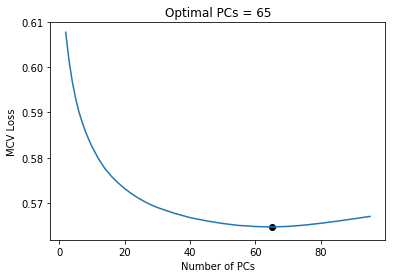

In [14]:
plot_mcv(mcv_summary)

In [15]:
adata.X = adata.raw.X
adata = recipe_seurat(adata)

/Users/josh/src/scanpy/scanpy/preprocessing/_simple.py:1145: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


In [16]:
sc.tl.pca(adata, n_comps=optimal_k, zero_center=False)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.leiden(adata)
sc.tl.umap(adata)

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


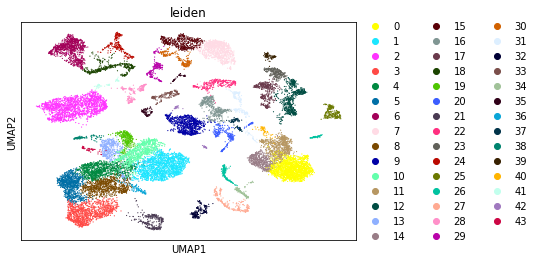

In [17]:
sc.pl.umap(adata, color=['leiden'])